In [1]:
import numpy as np

In [2]:
def load_sim_data():
    """
    测试数据，
    :return: data_arr   feature对应的数据集
            label_arr  feature对应的分类标签
    """
    data_mat = np.matrix([[1.0, 2.1],
                          [2.0, 1.1],
                          [1.3, 1.0],
                          [1.0, 1.0],
                          [2.0, 1.0]])
    class_labels = [1.0, 1.0, -1.0, -1.0, 1.0]
    return data_mat, class_labels

In [13]:
datMat,classLabels=load_sim_data()

In [6]:
def stump_classify(data_mat, dimen, thresh_val, thresh_ineq):
    """
    (将数据集，按照feature列的value进行 二分法切分比较来赋值分类)
    :param data_mat: Matrix数据集
    :param dimen: 特征的哪一个列
    :param thresh_val: 特征列要比较的值
    :param thresh_ineq: 
    :return: np.array
    """
    ret_array = np.ones((np.shape(data_mat)[0], 1))
    # data_mat[:, dimen] 表示数据集中第dimen列的所有值
    # thresh_ineq == 'lt'表示修改左边的值，gt表示修改右边的值
    # （这里其实我建议理解为转换左右边，就是一棵树的左右孩子，可能有点问题。。。待考证）
    if thresh_ineq == 'lt':
        ret_array[data_mat[:, dimen] <= thresh_val] = -1.0
    else:
        ret_array[data_mat[:, dimen] > thresh_val] = -1.0
    return ret_array

In [5]:
def build_stump(data_arr, class_labels, D):
    """
    得到决策树的模型 (这个比较重要，需要看懂）
    :param data_arr: 特征标签集合
    :param class_labels: 分类标签集合
    :param D: 最初的特征权重值
    :return: bestStump    最优的分类器模型
            min_error     错误率
            best_class_est  训练后的结果集
    """
    data_mat = np.mat(data_arr)
    label_mat = np.mat(class_labels).T

    m, n = np.shape(data_mat)
    num_steps = 10.0
    best_stump = {}
    best_class_est = np.mat(np.zeros((m, 1)))
    # 无穷大
    min_err = np.inf
    for i in range(n):
        range_min = data_mat[:, i].min()
        range_max = data_mat[:, i].max()
        step_size = (range_max - range_min) / num_steps
        for j in range(-1, int(num_steps) + 1):
            for inequal in ['lt', 'gt']:
                thresh_val = (range_min + float(j) * step_size)
                predicted_vals = stump_classify(data_mat, i, thresh_val, inequal)
                err_arr = np.mat(np.ones((m, 1)))
                err_arr[predicted_vals == label_mat] = 0
                # 这里是矩阵乘法
                weighted_err = D.T * err_arr
                '''
                dim            表示 feature列
                thresh_val      表示树的分界值
                inequal        表示计算树左右颠倒的错误率的情况
                weighted_error  表示整体结果的错误率
                best_class_est    预测的最优结果 （与class_labels对应）
                '''
                # print('split: dim {}, thresh {}, thresh inequal: {}, the weighted err is {}'.format(
                #     i, thresh_val, inequal, weighted_err
                # ))
                if weighted_err < min_err:
                    min_err = weighted_err
                    best_class_est = predicted_vals.copy()
                    best_stump['dim'] = i
                    best_stump['thresh'] = thresh_val
                    best_stump['ineq'] = inequal
    # best_stump 表示分类器的结果，在第几个列上，用大于／小于比较，阈值是多少 (单个弱分类器)
    return best_stump, min_err, best_class_est

In [11]:
D=np.mat(np.ones((5,1))/5)

In [12]:
D

matrix([[0.2],
        [0.2],
        [0.2],
        [0.2],
        [0.2]])

In [14]:
build_stump(datMat,classLabels,D)

({'dim': 0, 'thresh': 1.3, 'ineq': 'lt'},
 matrix([[0.2]]),
 array([[-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.]]))

In [15]:

def ada_boost_train_ds(data_arr, class_labels, num_it=40):
    """
    adaBoost训练过程放大
    :param data_arr: 特征标签集合
    :param class_labels: 分类标签集合
    :param num_it: 迭代次数
    :return: weak_class_arr  弱分类器的集合
            agg_class_est   预测的分类结果值
    """
    weak_class_arr = []
    m = np.shape(data_arr)[0]
    # 初始化 D，设置每个特征的权重值，平均分为m份
    D = np.mat(np.ones((m, 1)) / m)
    agg_class_est = np.mat(np.zeros((m, 1)))
    for i in range(num_it):
        # 得到决策树的模型
        best_stump, error, class_est = build_stump(data_arr, class_labels, D)
        # print('D: {}'.format(D.T))
        # alpha 目的主要是计算每一个分类器实例的权重(加和就是分类结果)
        # 计算每个分类器的 alpha 权重值
        alpha = float(0.5 * np.log((1.0 - error) / max(error, 1e-16)))
        best_stump['alpha'] = alpha
        # store Stump Params in Array
        weak_class_arr.append(best_stump)
        # print('class_est: {}'.format(class_est.T))
        # 分类正确：乘积为1，不会影响结果，-1主要是下面求e的-alpha次方
        # 分类错误：乘积为 -1，结果会受影响，所以也乘以 -1
        expon = np.multiply(-1 * alpha * np.mat(class_labels).T, class_est)
        # 判断正确的，就乘以-1，否则就乘以1， 为什么？ 书上的公式。
        # print('(-1取反)预测值 expon=', expon.T)
        # 计算e的expon次方，然后计算得到一个综合的概率的值
        # 结果发现： 判断错误的样本，D对于的样本权重值会变大。
        # multiply是对应项相乘
        D = np.multiply(D, np.exp(expon))
        D = D / D.sum()
        # 预测的分类结果值，在上一轮结果的基础上，进行加和操作
        # print('叠加前的分类结果class_est: {}'.format(class_est.T))
        agg_class_est += alpha * class_est
        # print('叠加后的分类结果agg_class_est: {}'.format(agg_class_est.T))
        # sign 判断正为1， 0为0， 负为-1，通过最终加和的权重值，判断符号。
        # 结果为：错误的样本标签集合，因为是 !=,那么结果就是0 正, 1 负
        agg_errors = np.multiply(np.sign(agg_class_est) != np.mat(class_labels).T,
                                 np.ones((m, 1)))
        error_rate = agg_errors.sum() / m
        # print('total error: {}\n'.format(error_rate))
        if error_rate == 0.0:
            break
    return weak_class_arr, agg_class_est

In [28]:
def load_data_set(file_name):
    """
    加载马的疝气病的数据
    :param file_name: 文件名
    :return: 必须要是np.array或者np.matrix不然后面没有，shape
    """
    num_feat = len(open(file_name).readline().split('\t'))
    data_arr = []
    label_arr = []
    fr = open(file_name)
    for line in fr.readlines():
        line_arr = []
        cur_line = line.strip().split('\t')
        for i in range(num_feat - 1):
            line_arr.append(float(cur_line[i]))
        data_arr.append(line_arr)
        label_arr.append(float(cur_line[-1]))
    return data_arr, label_arr

In [24]:
def ada_classify(data_to_class, classifier_arr):
    """
    通过刚刚上面那个函数得到的弱分类器的集合进行预测
    :param data_to_class: 数据集
    :param classifier_arr: 分类器列表
    :return: 正负一，也就是表示分类的结果
    """
    data_mat = np.mat(data_to_class)
    m = np.shape(data_mat)[0]
    agg_class_est = np.mat(np.zeros((m, 1)))
    for i in range(len(classifier_arr)):
        class_est = stump_classify(
            data_mat, classifier_arr[i]['dim'],
            classifier_arr[i]['thresh'],
            classifier_arr[i]['ineq']
        )
        agg_class_est += classifier_arr[i]['alpha'] * class_est
        print(agg_class_est)
    return np.sign(agg_class_est)


def plot_roc(pred_strengths, class_labels):
    """
    (打印ROC曲线，并计算AUC的面积大小)
    :param pred_strengths: 最终预测结果的权重值
    :param class_labels: 原始数据的分类结果集
    :return: 
    """
    import matplotlib.pyplot as plt
    # variable to calculate AUC
    y_sum = 0.0
    # 对正样本的进行求和
    num_pos_class = np.sum(np.array(class_labels) == 1.0)
    # 正样本的概率
    y_step = 1 / float(num_pos_class)
    # 负样本的概率
    x_step = 1 / float(len(class_labels) - num_pos_class)
    # np.argsort函数返回的是数组值从小到大的索引值
    # get sorted index, it's reverse
    sorted_indicies = pred_strengths.argsort()
    # 测试结果是否是从小到大排列
    # 可以选择打印看一下
    # 开始创建模版对象
    fig = plt.figure()
    fig.clf()
    ax = plt.subplot(111)
    # cursor光标值
    cur = (1.0, 1.0)
    # loop through all the values, drawing a line segment at each point
    for index in sorted_indicies.tolist()[0]:
        if class_labels[index] == 1.0:
            del_x = 0
            del_y = y_step
        else:
            del_x = x_step
            del_y = 0
            y_sum += cur[1]
        # draw line from cur to (cur[0]-delX, cur[1]-delY)
        # 画点连线 (x1, x2, y1, y2)
        # print cur[0], cur[0]-delX, cur[1], cur[1]-delY
        ax.plot([cur[0], cur[0] - del_x], [cur[1], cur[1] - del_y], c='b')
        cur = (cur[0] - del_x, cur[1] - del_y)
    # 画对角的虚线线
    ax.plot([0, 1], [0, 1], 'b--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve for AdaBoost horse colic detection system')
    # 设置画图的范围区间 (x1, x2, y1, y2)
    ax.axis([0, 1, 0, 1])
    plt.show()
    '''
    参考说明：http://blog.csdn.net/wenyusuran/article/details/39056013
    为了计算 AUC ，我们需要对多个小矩形的面积进行累加。
    这些小矩形的宽度是x_step，因此可以先对所有矩形的高度进行累加，最后再乘以x_step得到其总面积。
    所有高度的和(y_sum)随着x轴的每次移动而渐次增加。
    '''
    print("the Area Under the Curve is: ", y_sum * x_step)

In [29]:
data_mat,class_labels=load_data_set("data/horseColicTraining2.txt")

In [30]:
   weak_class_arr, agg_class_est = ada_boost_train_ds(np.mat(data_mat), class_labels, 10)

In [22]:
 data_arr_test, label_arr_test =load_data_set("data/horseColicTest2.txt")

In [25]:
    predicting10 = ada_classify(data_arr_test, weak_class_arr)

[[ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [-0.46166238]
 [-0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166

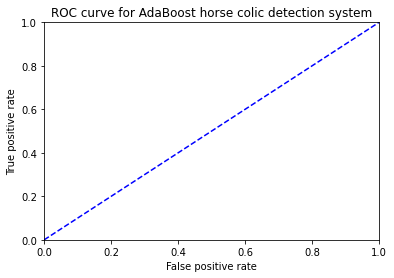

the Area Under the Curve is:  -0.2718181818181818


In [31]:
plot_roc(agg_class_est.T,data_mat)